In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Analyze Brain Tumor Images for Sub-pixel Based CNN Super Resolution Network

In [2]:
## Load all the necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio


from matplotlib.pyplot import imread
import h5py
import cv2

In [3]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [4]:
## Load Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = h5py.File(os.path.join(d,f), 'r')
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files), 'file: ', files[0])
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files   

In [5]:
## Load Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [6]:
files = load_data("../input/mydataset/BrainTumorData/", ".mat")

directory path:  ../input/mydataset/BrainTumorData/
directories:  ['../input/mydataset/BrainTumorData/']
list of files:  3064 file:  <HDF5 file "2912.mat" (mode r)>
list of files path:  3064 file path:  ../input/mydataset/BrainTumorData/2912.mat
Files Read:  3064


## Analyzing Attributes of .mat file using HDF5

In [7]:
print(files[0].keys())
print(files[0]['cjdata'])
print(files[0]['cjdata']['PID'])
print(files[0]['cjdata']['image'])
print(files[0]['cjdata']['label'])
print(files[0]['cjdata']['tumorBorder'])
print(files[0]['cjdata']['tumorMask'])

<KeysViewHDF5 ['cjdata']>
<HDF5 group "/cjdata" (5 members)>
<HDF5 dataset "PID": shape (9, 1), type "<u2">
<HDF5 dataset "image": shape (512, 512), type "<i2">
<HDF5 dataset "label": shape (1, 1), type "<f8">
<HDF5 dataset "tumorBorder": shape (1, 30), type "<f8">
<HDF5 dataset "tumorMask": shape (512, 512), type "|u1">


## Attributes and their meaning

### Here we can clearly see that image has following attributes:

1. cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
2. cjdata.PID: patient ID
3. cjdata.image: image data
4. cjdata.tumorBorder: a vector storing the coordinates of discrete points on the tumour border. For example, [x1, y1, x2, y2,…] in which x1, y1 are planar coordinates on tumour border. It was generated by manually delineating the tumour border. So we can use it to generate binary image of tumour mask.
5. cjdata.tumorMask: a binary image with 1s indicating tumour region

## Let's print each attribute one by one

In [8]:
## cjdata.PID: patient ID

print('Patient ID: ', files[0]['cjdata']['PID'][()])

Patient ID:  [[77]
 [82]
 [48]
 [53]
 [48]
 [55]
 [57]
 [49]
 [66]]


In [9]:
## cjdata.image: image data

print('Tumour Image Array: ', files[0]['cjdata']['image'][()])

Tumour Image Array:  [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 3  3 14 ... 14 13 13]
 [ 3  3 12 ... 12 11 11]
 [ 2  2 11 ...  8 10 10]]


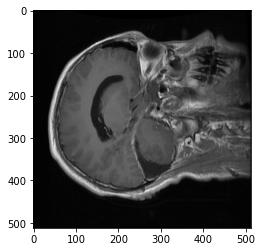

In [10]:
plt.imshow(files[0]['cjdata']['image'][()].squeeze(), cmap='gray')

## Let's analyze the image attributes

In [11]:
img = PIL.Image.fromarray(files[0]['cjdata']['image'][()])
print(img.format)
print(img.mode)
print(img.size)
print(img.palette)
print(img.info)

None
I
(512, 512)
None
{}


In [12]:
## cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor

print('label: ', files[0]['cjdata']['label'][()])

label:  [[2.]]


In [13]:
## cjdata.tumorBorder: a vector storing the coordinates of discrete points on the tumour border. 
## For example, [x1, y1, x2, y2,…] in which x1, y1 are planar coordinates on tumour border. 
## It was generated by manually delineating the tumour border. So we can use it to generate binary image of tumour mask.

print('Tumour Border: ', files[0]['cjdata']['tumorBorder'][()])

Tumour Border:  [[294.3554007  240.83623693 322.00696864 239.94425087 349.65853659
  247.08013937 382.66202091 258.67595819 394.25783972 265.81184669
  396.04181185 276.51567944 393.36585366 291.67944251 379.98606272
  313.08710801 366.60627178 322.8989547  361.2543554  322.8989547
  360.36236934 302.38327526 355.01045296 278.29965157 349.65853659
  264.02787456 325.57491289 249.75609756 305.05923345 246.18815331]]


In [14]:
## cjdata.tumorMask: a binary image with 1s indicating tumour region

print('Tumour Mask: ',files[0]['cjdata']['tumorMask'][()])

Tumour Mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Let's visualize the tumor mask

(-0.5, 511.5, 511.5, -0.5)

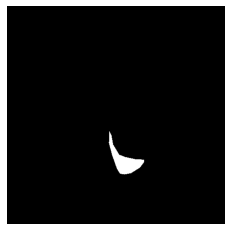

In [15]:
plt.imshow(files[0]['cjdata']['tumorMask'][()].squeeze(), cmap='gray')
plt.axis('off')

## Let's extract the images and their respective masks

In [16]:
## Lets extract 1000 images 

images_h5 = files[:500]

In [17]:
image_arr = [img_h5['cjdata']['image'][()].astype(np.uint32) for img_h5 in images_h5]

In [18]:
mask_arr = [img_h5['cjdata']['tumorMask'][()].astype(np.uint32) for img_h5 in images_h5]

## Let's see if there are any invalid shape images. Since we only want to process 512x512 images

In [19]:
# checking for invalid shape images

for idx, img in enumerate(image_arr):
    if img.shape != (512,512):
        print(idx, img.shape)

154 (256, 256)
479 (256, 256)


## Lets create a function to display 10 images in our dataset

In [20]:
def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(np.asarray(img_arr[i], dtype=float).squeeze(), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

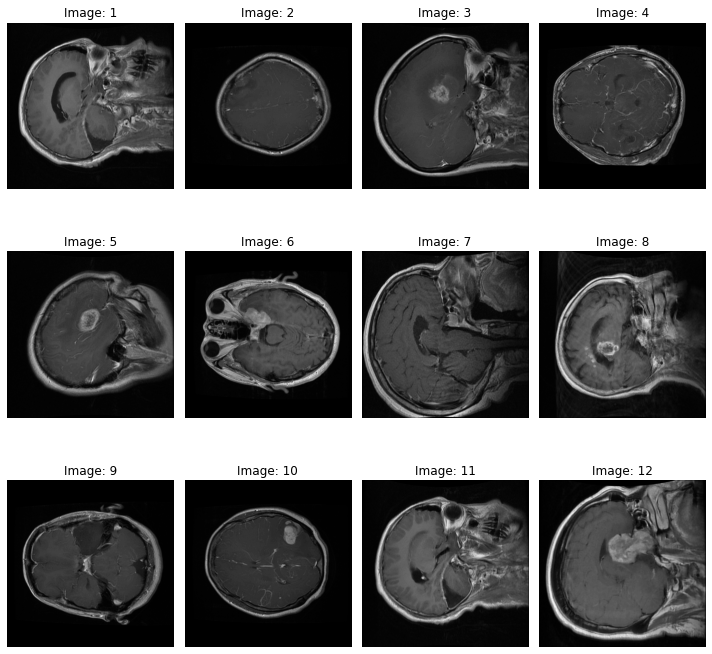

In [21]:
## Display intial 10 images in our image array

displayImages(image_arr)

### Let's get Tumour Region with the help of mask

In [22]:
for img in image_arr:
    im = array(img)

In [23]:
## To each image we apply the mask and store the result in the tumor array

tumour_arr = [img * mask for img, mask in zip(image_arr, mask_arr)]

## Now we will display the tumor region

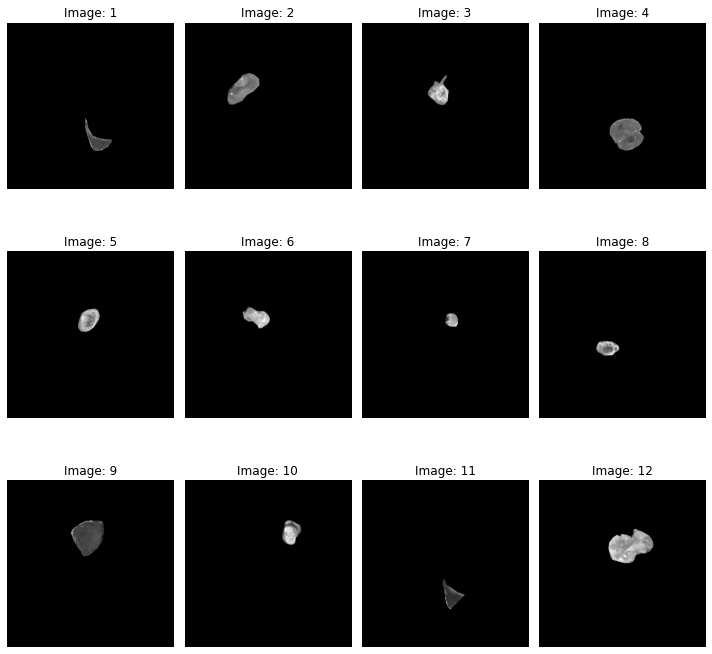

In [24]:
displayImages(tumour_arr)

In [25]:
image_arr[0]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 3,  3, 14, ..., 14, 13, 13],
       [ 3,  3, 12, ..., 12, 11, 11],
       [ 2,  2, 11, ...,  8, 10, 10]], dtype=uint32)

In [26]:
img_cords = []
img_pixels = []
image = image_arr[0]
rows = len(image)
cols = len(image[0])
for i in range(rows):
    for j in range(cols):
        if image[i][j] != 0:
            img_pixels.append(image[i][j])
            img_cords.append((i,j))

In [27]:
print(img_pixels)

[4, 17, 26, 39, 42, 33, 26, 27, 31, 30, 26, 40, 51, 41, 40, 42, 38, 41, 45, 37, 32, 36, 42, 43, 43, 37, 37, 46, 39, 43, 49, 52, 51, 46, 39, 30, 23, 29, 38, 22, 37, 34, 43, 50, 54, 46, 44, 45, 39, 50, 36, 43, 42, 60, 53, 36, 37, 37, 48, 51, 54, 39, 34, 49, 53, 34, 40, 56, 53, 41, 47, 49, 36, 38, 56, 49, 45, 39, 49, 52, 39, 25, 8, 3, 23, 42, 37, 36, 39, 36, 26, 33, 47, 39, 43, 41, 48, 52, 49, 47, 49, 49, 36, 53, 44, 38, 49, 45, 53, 51, 31, 50, 54, 46, 42, 33, 36, 56, 62, 33, 28, 47, 44, 35, 42, 47, 52, 52, 39, 34, 43, 42, 55, 49, 45, 56, 33, 36, 37, 65, 54, 51, 54, 45, 27, 40, 60, 55, 53, 49, 34, 32, 43, 51, 40, 46, 52, 53, 44, 37, 30, 31, 39, 38, 32, 33, 41, 41, 30, 26, 42, 33, 24, 34, 33, 41, 52, 51, 37, 27, 25, 27, 26, 20, 18, 20, 20, 6, 5, 14, 23, 37, 42, 37, 29, 29, 29, 27, 29, 35, 45, 37, 50, 40, 27, 42, 46, 34, 38, 37, 37, 38, 55, 49, 31, 43, 36, 36, 48, 46, 49, 51, 36, 26, 31, 29, 44, 36, 33, 38, 51, 53, 58, 52, 45, 45, 46, 57, 41, 38, 44, 55, 50, 38, 39, 34, 47, 69, 69, 38, 31, 

In [28]:
mask_arr[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [29]:
cords = []
pixels = []
image = tumour_arr[0]
rows = len(image)
cols = len(image[0])
for i in range(rows):
    for j in range(cols):
        if image[i][j] != 0:
            pixels.append(image[i][j])
            cords.append((i,j))

In [30]:
print(pixels)

[877, 793, 725, 728, 692, 667, 703, 669, 690, 744, 666, 658, 797, 672, 651, 779, 825, 707, 687, 747, 826, 734, 714, 736, 843, 814, 745, 726, 750, 813, 790, 734, 716, 740, 801, 815, 759, 703, 672, 706, 779, 826, 714, 651, 618, 641, 725, 804, 661, 588, 552, 565, 634, 726, 608, 534, 499, 502, 547, 624, 574, 494, 467, 470, 490, 535, 556, 467, 458, 465, 481, 485, 548, 544, 444, 437, 453, 473, 473, 512, 531, 424, 412, 435, 467, 473, 505, 519, 414, 394, 417, 456, 475, 514, 521, 421, 397, 413, 447, 474, 516, 538, 446, 421, 427, 450, 475, 521, 599, 556, 469, 450, 449, 459, 478, 526, 597, 565, 472, 463, 461, 464, 481, 530, 598, 563, 461, 451, 455, 459, 478, 531, 602, 734, 567, 443, 419, 440, 448, 468, 527, 608, 757, 593, 453, 412, 435, 441, 452, 515, 611, 807, 643, 488, 435, 451, 451, 439, 496, 610, 742, 703, 532, 470, 480, 472, 446, 483, 603, 746, 749, 566, 491, 498, 493, 478, 481, 591, 737, 775, 583, 495, 498, 505, 506, 503, 576, 709, 790, 599, 492, 491, 513, 539, 541, 568, 661, 632, 514, 498,

In [31]:
print(cords)

[(294, 240), (295, 240), (296, 240), (296, 241), (297, 240), (297, 241), (298, 240), (298, 241), (298, 242), (299, 240), (299, 241), (299, 242), (300, 240), (300, 241), (300, 242), (300, 243), (301, 240), (301, 241), (301, 242), (301, 243), (302, 240), (302, 241), (302, 242), (302, 243), (302, 244), (303, 240), (303, 241), (303, 242), (303, 243), (303, 244), (304, 240), (304, 241), (304, 242), (304, 243), (304, 244), (304, 245), (305, 240), (305, 241), (305, 242), (305, 243), (305, 244), (305, 245), (306, 240), (306, 241), (306, 242), (306, 243), (306, 244), (306, 245), (307, 240), (307, 241), (307, 242), (307, 243), (307, 244), (307, 245), (308, 240), (308, 241), (308, 242), (308, 243), (308, 244), (308, 245), (309, 240), (309, 241), (309, 242), (309, 243), (309, 244), (309, 245), (310, 240), (310, 241), (310, 242), (310, 243), (310, 244), (310, 245), (310, 246), (311, 240), (311, 241), (311, 242), (311, 243), (311, 244), (311, 245), (311, 246), (312, 240), (312, 241), (312, 242), (31

In [32]:
x1, y1 = cords[0]
x2, y2 = cords[-1]

In [33]:
start_point = cords[0]
end_point = cords[1]
color = (255, 0, 0) 
# Line thickness of 2 px 
thickness = 3
res = cv2.rectangle(np.array(tumour_arr[0], dtype='float'), (x1, y1), (x2, y2), (255,0,0), 10) 

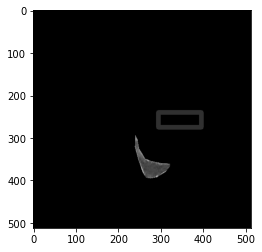

In [34]:
plt.imshow(res, cmap='gray')

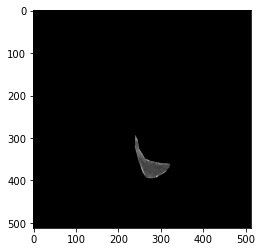

In [35]:
plt.imshow(tumour_arr[0], cmap='gray')

In [36]:
img = cv2.normalize(np.float32(tumour_arr[0]), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img = img.astype(np.uint32)

In [37]:
print(type(img))

<class 'numpy.ndarray'>


In [38]:
tumors = []
for img in tumour_arr:
    img = cv2.normalize(np.float32(tumour_arr[0]), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    tumors.append(img.astype(np.uint32))

In [39]:
for img in tumors:
    min_val, max_val = img.min(), img.max()
    print(min_val, max_val)

0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 25

In [40]:
# ret, thresh = cv2.threshold(np.uint32(img),min_val,max_val,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [41]:
os.mkdir('./tumor')

In [42]:
for idx in range(500):
    imageio.imwrite('./tumor/TMR_'+str(idx+1)+'.jpeg', np.asarray(tumour_arr[idx], dtype=float))

In [43]:
%%!

zip -r tumor.zip ./tumor

['  adding: tumor/ (stored 0%)',
 '  adding: tumor/TMR_337.jpeg (deflated 63%)',
 '  adding: tumor/TMR_356.jpeg (deflated 49%)',
 '  adding: tumor/TMR_262.jpeg (deflated 47%)',
 '  adding: tumor/TMR_253.jpeg (deflated 68%)',
 '  adding: tumor/TMR_365.jpeg (deflated 66%)',
 '  adding: tumor/TMR_400.jpeg (deflated 68%)',
 '  adding: tumor/TMR_261.jpeg (deflated 64%)',
 '  adding: tumor/TMR_288.jpeg (deflated 53%)',
 '  adding: tumor/TMR_489.jpeg (deflated 53%)',
 '  adding: tumor/TMR_100.jpeg (deflated 61%)',
 '  adding: tumor/TMR_217.jpeg (deflated 72%)',
 '  adding: tumor/TMR_51.jpeg (deflated 62%)',
 '  adding: tumor/TMR_221.jpeg (deflated 66%)',
 '  adding: tumor/TMR_185.jpeg (deflated 56%)',
 '  adding: tumor/TMR_115.jpeg (deflated 77%)',
 '  adding: tumor/TMR_122.jpeg (deflated 75%)',
 '  adding: tumor/TMR_411.jpeg (deflated 40%)',
 '  adding: tumor/TMR_344.jpeg (deflated 74%)',
 '  adding: tumor/TMR_363.jpeg (deflated 45%)',
 '  adding: tumor/TMR_144.jpeg (deflated 75%)',
 '  addi